In [1]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [2]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Importing the dataset
with open('kampus_merdeka_new.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data 

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
247,Lokasi KKNT?,lokasi_kknt
248,Berapa lama program KKNT?,jangka_waktu_kknt
249,Jangka waktu program KKNT?,jangka_waktu_kknt
250,jangka waktu KKNT?,jangka_waktu_kknt


In [5]:
# Cetak data baris pertama sampai baris kelima
data.head() 

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [6]:
# Cetak data baris ke-70 sampai baris akhir
data.tail() 

,patterns,tags
247,Lokasi KKNT?,lokasi_kknt
248,Berapa lama program KKNT?,jangka_waktu_kknt
249,Jangka waktu program KKNT?,jangka_waktu_kknt
250,jangka waktu KKNT?,jangka_waktu_kknt
251,lama program KKNT?,jangka_waktu_kknt


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  252 non-null    object
 1   tags      252 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


In [8]:
data['patterns']

0                           hallo
1                             hai
2                            halo
3                             hei
4                              hi
                  ...            
247                  Lokasi KKNT?
248     Berapa lama program KKNT?
249    Jangka waktu program KKNT?
250            jangka waktu KKNT?
251            lama program KKNT?
Name: patterns, Length: 252, dtype: object

# Preprocessing

In [9]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
247,lokasi kknt,lokasi_kknt
248,berapa lama program kknt,jangka_waktu_kknt
249,jangka waktu program kknt,jangka_waktu_kknt
250,jangka waktu kknt,jangka_waktu_kknt


In [10]:
data['patterns']

0                          hallo
1                            hai
2                           halo
3                            hei
4                             hi
                 ...            
247                  lokasi kknt
248     berapa lama program kknt
249    jangka waktu program kknt
250            jangka waktu kknt
251            lama program kknt
Name: patterns, Length: 252, dtype: object

In [11]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

135 unique lemmatized words ['ada', 'adalah', 'afternoon', 'akan', 'apa', 'apabila', 'apakah', 'bagaimana', 'bagimana', 'bangkit', 'banyak', 'bayar', 'berapa', 'berlangsung', 'bersertifikat', 'bersetifikat', 'biaya', 'bidang', 'bidang/jurusan', 'bisa', 'boleh', 'bumn', 'bye', 'byee', 'cara', 'dadah', 'daftar', 'daftarkan', 'dah', 'dalam', 'dan', 'dapat', 'dari', 'dengan', 'di', 'didapatkan', 'dilakukan', 'dimana', 'evening', 'excuse', 'gaji', 'good', 'hai', 'hallo', 'halo', 'harus', 'hei', 'hi', 'hy', 'iisma', 'independen', 'ittpbot', 'itu', 'jalur', 'jangka', 'jenis', 'jenjang', 'jumpa', 'jurursan', 'jurusan', 'kampus', 'kamu', 'kasih', 'kegiatan', 'kemendikbud', 'kemensos', 'kknt', 'lama', 'lokasi', 'lowongan', 'luar', 'magang', 'mahasiswa', 'makasih', 'malam', 'mana', 'manfaat', 'masih', 'me', 'megikuti', 'membayar', 'mendaftar', 'mendapatkan', 'menerima', 'mengajar', 'mengikuti', 'merdeka', 'mitra', 'morning', 'muda', 'pada', 'pagi', 'pejuang', 'pelaksanaan', 'pembelajaran', 'pergu

In [12]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

61 classes ['ITTPBot', 'biaya_studi_independen', 'daftar_lowongan_magang', 'gaji_magang', 'goodbye', 'greeting', 'jangka_waktu_kknt', 'jenis_kampus_merdeka', 'jurusan_magang', 'jurusan_studi_independen', 'lokasi_kknt', 'lowongan_magang', 'manfaat_IISMA', 'manfaat_PMMB', 'manfaat_bangkit', 'manfaat_kampus_mengajar', 'manfaat_kknt', 'manfaat_magang', 'manfaat_pejuang_muda', 'manfaat_pertukaran_mahasiswa', 'manfaat_studi_independen', 'mitra_IISMA', 'mitra_PMMB', 'mitra_magang', 'mitra_studi_independen', 'pelaksanaan_studi_independen', 'penjelasan_IISMA', 'penjelasan_PMMB', 'penjelasan_bangkit', 'penjelasan_kampus_mengajar', 'penjelasan_kampus_merdeka', 'penjelasan_kknt', 'penjelasan_magang', 'penjelasan_pejuang_muda', 'penjelasan_pertukaran_mahasiswa', 'penjelasan_studi_independen', 'perguruan_tinggi_magang', 'perguruan_tinggi_studi_independen', 'periode_dan_pendaftaran_IISMA', 'periode_dan_pendaftaran_PMMB', 'periode_dan_pendaftaran_kampus_mengajar', 'periode_dan_pendaftaran_magang', 'pe

In [13]:
# documents = combination between patterns and intents
print (len(documents), "documents")

1204 documents


In [14]:
pickle.dump(words, open('model-new/words.pkl','wb'))
pickle.dump(classes, open('model-new/classes.pkl','wb'))

C:\Users\rhjha\AppData\Local\Temp\ipykernel_7208\3012069438.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


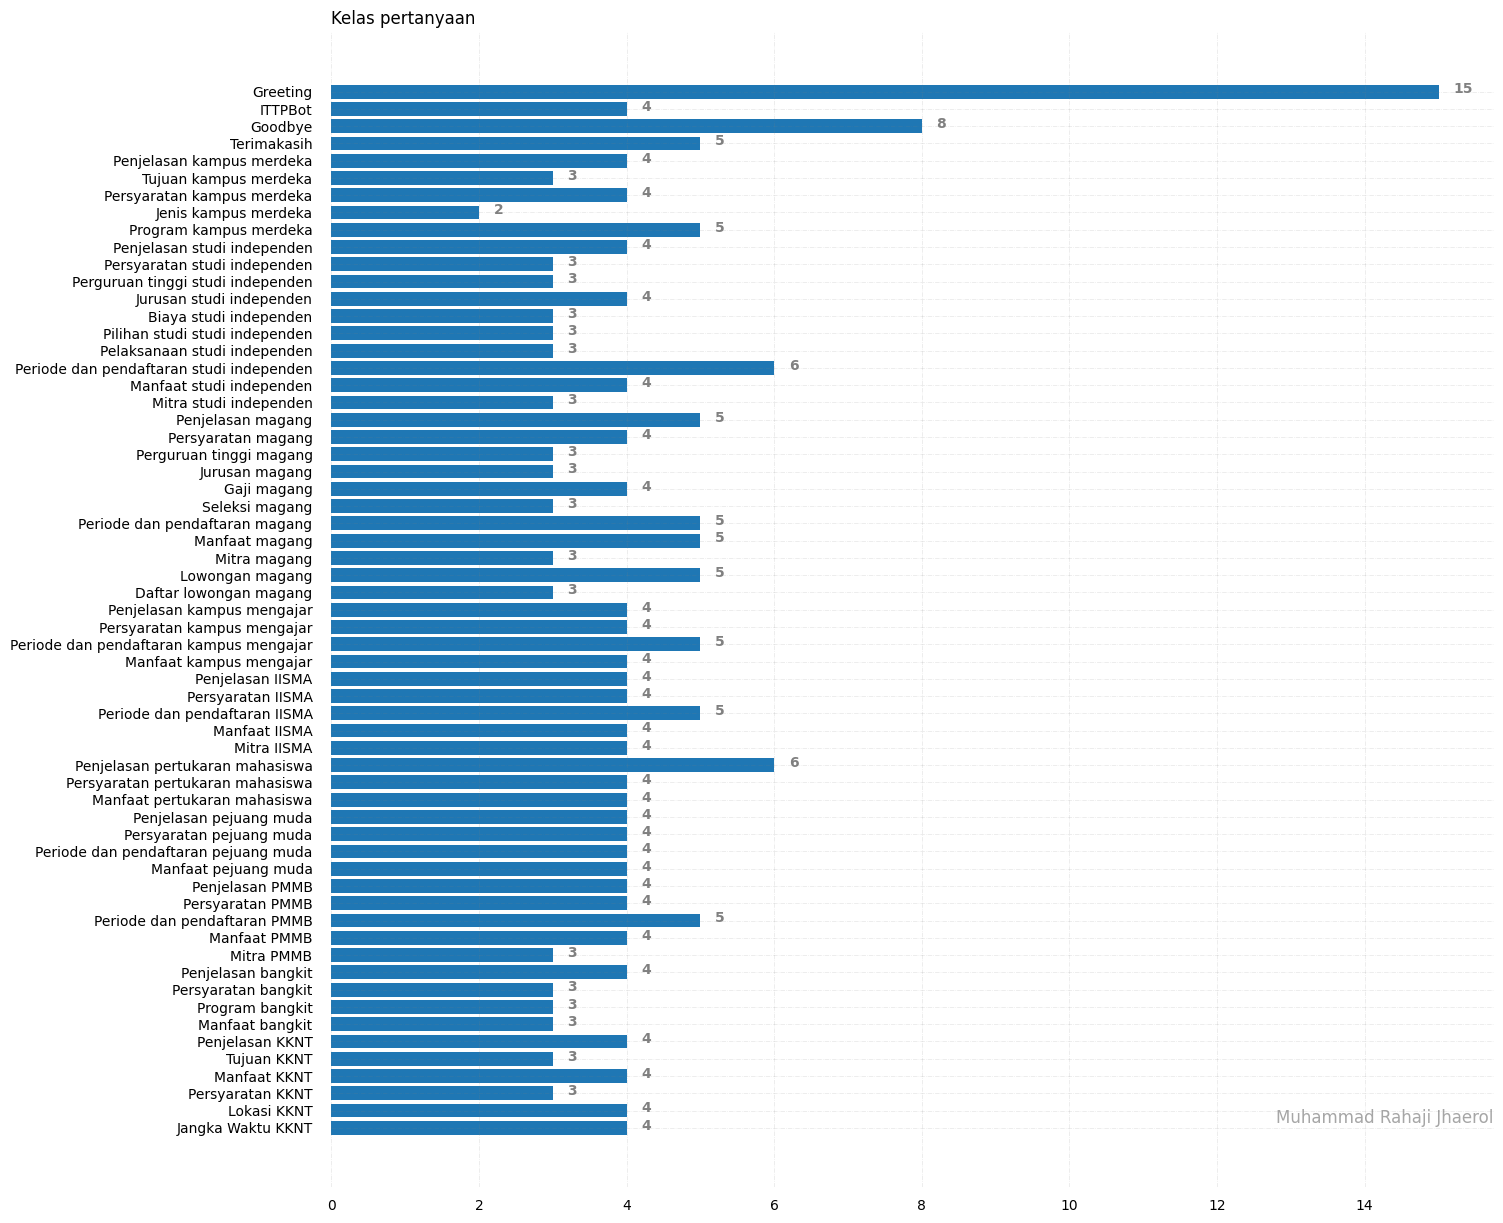

In [15]:
import pandas as pd
from matplotlib import pyplot as plt

# Read CSV into pandas
datalabel = {"Greeting":15, "ITTPBot":4, "Goodbye":8, "Terimakasih":5, "Penjelasan kampus merdeka":4, "Tujuan kampus merdeka":3, 
        "Persyaratan kampus merdeka":4, "Jenis kampus merdeka":2, "Program kampus merdeka":5, "Penjelasan studi independen":4, 
        "Persyaratan studi independen":3, "Perguruan tinggi studi independen":3, "Jurusan studi independen":4, 
        "Biaya studi independen":3, "Pilihan studi studi independen":3, "Pelaksanaan studi independen":3, 
        "Periode dan pendaftaran studi independen":6, "Manfaat studi independen":4, "Mitra studi independen":3, 
        "Penjelasan magang":5, "Persyaratan magang":4, "Perguruan tinggi magang":3, "Jurusan magang":3, "Gaji magang":4, 
        "Seleksi magang":3, "Periode dan pendaftaran magang":5,  "Manfaat magang":5, "Mitra magang":3, "Lowongan magang":5, 
        "Daftar lowongan magang":3, "Penjelasan kampus mengajar":4, "Persyaratan kampus mengajar":4, 
        "Periode dan pendaftaran kampus mengajar":5, "Manfaat kampus mengajar":4, "Penjelasan IISMA":4, "Persyaratan IISMA":4,  
        "Periode dan pendaftaran IISMA":5, "Manfaat IISMA":4, "Mitra IISMA":4, "Penjelasan pertukaran mahasiswa":6, 
        "Persyaratan pertukaran mahasiswa":4, "Manfaat pertukaran mahasiswa":4, "Penjelasan pejuang muda":4, 
        "Persyaratan pejuang muda":4, "Periode dan pendaftaran pejuang muda":4, "Manfaat pejuang muda":4, "Penjelasan PMMB":4, 
        "Persyaratan PMMB":4, "Periode dan pendaftaran PMMB":5, "Manfaat PMMB":4, "Mitra PMMB":3, "Penjelasan bangkit":4, 
        "Persyaratan bangkit":3, "Program bangkit":3, "Manfaat bangkit":3, "Penjelasan KKNT":4, "Tujuan KKNT":3, "Manfaat KKNT":4, 
        "Persyaratan KKNT":3, "Lokasi KKNT":4, "Jangka Waktu KKNT":4}

name = list(datalabel.keys())
price = list(datalabel.values())

# Figure Size
fig, ax = plt.subplots(figsize =(15, 15))

# Horizontal Bar Plot
ax.barh(name, price)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5, alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Kelas pertanyaan', loc ='left', )

# Add Text watermark
fig.text(0.9, 0.15, 'Muhammad Rahaji Jhaerol', fontsize = 12,
         color ='grey', ha ='right', va ='bottom', alpha = 0.7)

# save plot
plt.savefig('model-new/kelas_pertanyaan.png', dpi=300, bbox_inches='tight')

# Show Plot
plt.show()



In [16]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train_sequence = tokenizer.texts_to_sequences(data['patterns'])
train_sequence

[[84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98, 99],
 [1, 25, 62],
 [53, 62],
 [63, 53],
 [53, 63],
 [100],
 [101],
 [64],
 [102],
 [103, 64],
 [104, 105],
 [106, 107],
 [108, 65],
 [109],
 [110, 65],
 [66, 67],
 [111],
 [66, 67, 46],
 [1, 25, 6, 10],
 [1, 6, 10],
 [6, 10],
 [6, 10, 30],
 [1, 41, 6, 10],
 [41, 6, 10, 30],
 [41, 26, 6, 10],
 [1, 27, 4, 6, 10],
 [13, 6, 10],
 [13, 4, 6, 10],
 [1, 13, 6, 10],
 [1, 3, 68, 2, 6, 10],
 [68, 2, 6, 10],
 [1, 3, 2, 6, 10],
 [2, 6, 10],
 [2, 6, 10, 112],
 [2, 6, 10, 113],
 [2, 6, 10, 114],
 [1, 25, 7, 9],
 [7, 9],
 [1, 7, 9],
 [7, 9, 30],
 [1, 3, 27, 7, 9],
 [13, 7, 9],
 [1, 13, 7, 9],
 [11, 26, 69, 70, 1, 3, 12, 17, 4, 2, 7, 9],
 [11, 26, 47, 3, 12, 17, 4, 2, 7, 9],
 [11, 26, 47, 3, 12, 17, 4, 7, 9],
 [11, 26, 43, 37, 48, 1, 3, 12, 17, 4, 2, 7, 9],
 [11, 26, 43, 1, 12, 17, 4, 2, 7, 9],
 [11, 26, 43, 1, 12, 17, 4, 7, 9],
 [11, 115, 48, 1, 3, 12, 17, 4, 2, 7, 9],
 [19, 11, 12, 4, 2, 7, 9, 71

In [17]:
tokenizer.word_index

{'apa': 1,
 'program': 2,
 'saja': 3,
 'mengikuti': 4,
 'magang': 5,
 'kampus': 6,
 'studi': 7,
 'manfaat': 8,
 'independen': 9,
 'merdeka': 10,
 'mahasiswa': 11,
 'yang': 12,
 'syarat': 13,
 'kknt': 14,
 'iisma': 15,
 'pmmb': 16,
 'dapat': 17,
 'cara': 18,
 'apakah': 19,
 'periode': 20,
 'mendaftar': 21,
 'mengajar': 22,
 'pejuang': 23,
 'muda': 24,
 'itu': 25,
 'dari': 26,
 'persyaratan': 27,
 'bagaimana': 28,
 'bangkit': 29,
 'adalah': 30,
 'bersertifikat': 31,
 'pertukaran': 32,
 'berapa': 33,
 'mitra': 34,
 'pelaksanaan': 35,
 'lama': 36,
 'dan': 37,
 'saya': 38,
 'lowongan': 39,
 'apabila': 40,
 'tujuan': 41,
 'di': 42,
 'jurusan': 43,
 'dalam': 44,
 'daftar': 45,
 'banyak': 46,
 'mana': 47,
 'jenjang': 48,
 'bisa': 49,
 'tergabung': 50,
 'universitas': 51,
 'gaji': 52,
 'siapa': 53,
 'pilihan': 54,
 'harus': 55,
 'dengan': 56,
 'perkuliahan': 57,
 'selama': 58,
 'daftarkan': 59,
 'pmm': 60,
 'lokasi': 61,
 'ittpbot': 62,
 'kamu': 63,
 'bye': 64,
 'you': 65,
 'terima': 66,
 'kasi

In [18]:
train_sequence[:20]

[[84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98, 99],
 [1, 25, 62],
 [53, 62],
 [63, 53],
 [53, 63],
 [100]]

In [19]:
# Apply padding 
x_train = pad_sequences(train_sequence)
print(x_train[:20]) # Padding Sequences

[[  0   0   0   0   0   0   0   0   0   0   0   0   0  84]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  85]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  86]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  87]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  88]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  89]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  90]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  91]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  92]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  93]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  94]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  95]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  96]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  97]
 [  0   0   0   0   0   0   0   0   0   0   0   0  98  99]
 [  0   0   0   0   0   0   0   0   0   0   0   1  25  62]
 [  0   0   0   0   0   0   0   0   0   0   0   0  53  6

In [20]:
x_train.shape

(252, 14)

In [21]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  0  0  0  0  4  4  4  4  4
  4  4  4 58 58 58 58 58 30 30 30 30 59 59 59 48 48 48 48  7  7 56 56 56
 56 56 35 35 35 35 52 52 52 37 37 37  9  9  9  9  1  1  1 54 54 54 25 25
 25 43 43 43 43 43 43 20 20 20 20 24 24 24 32 32 32 32 32 49 49 49 49 36
 36 36  8  8  8  3  3  3  3 57 57 57 41 41 41 41 41 17 17 17 17 17 23 23
 23 11 11 11 11 11  2  2  2 29 29 29 29 47 47 47 47 40 40 40 40 40 15 15
 15 15 26 26 26 26 44 44 44 44 38 38 38 38 38 12 12 12 12 21 21 21 21 34
 34 34 34 34 34 51 51 51 51 19 19 19 19 33 33 33 33 50 50 50 50 42 42 42
 42 18 18 18 18 27 27 27 27 45 45 45 45 39 39 39 39 39 13 13 13 13 22 22
 22 28 28 28 28 46 46 46 55 55 55 14 14 14 31 31 31 31 60 60 60 16 16 16
 16 53 53 53 10 10 10 10  6  6  6  6]


In [22]:
y_train.shape

(252,)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(226, 14) (226,)
(26, 14) (26,)


In [24]:
# input length
input_shape = X_train.shape[1]
print(input_shape)

14


In [25]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  135
output length:  61


In [26]:
pickle.dump(le, open('model-new/le.pkl','wb'))
pickle.dump(tokenizer, open('model-new/tokenizers.pkl','wb'))

# Eksperimen1

In [26]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(2, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model1  = Model(i,x)

# Compiling the model (Kompilasi Model)
model1.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [27]:
# Menampilkan Parameter Model
model1.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding (Embedding)       (None, 14, 10)            1360      
                                                                 
 lstm (LSTM)                 (None, 14, 2)             104       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 61)                1769      
                                                                 
Total params: 3,233
Trainable params: 3,233
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model-new/model_plot.png', show_shapes=True, show_layer_names=True)

In [28]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model1.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 21s 92ms/step - loss: 4.1109 - accuracy: 0.0177
Epoch 2/100
4/4 [==============================] - 0s 71ms/step - loss: 4.1087 - accuracy: 0.0265
Epoch 3/100
4/4 [==============================] - 0s 72ms/step - loss: 4.1070 - accuracy: 0.0265
Epoch 4/100
4/4 [==============================] - 0s 72ms/step - loss: 4.1052 - accuracy: 0.0310
Epoch 5/100
4/4 [==============================] - 0s 69ms/step - loss: 4.1031 - accuracy: 0.0354
Epoch 6/100
4/4 [==============================] - 0s 72ms/step - loss: 4.1011 - accuracy: 0.0885
Epoch 7/100
4/4 [==============================] - 0s 78ms/step - loss: 4.0986 - accuracy: 0.0885
Epoch 8/100
4/4 [==============================] - 0s 69ms/step - loss: 4.0961 - accuracy: 0.0885
Epoch 9/100
4/4 [==============================] - 0s 71ms/step - loss: 4.0929 - accuracy: 0.0885
Epoch 10/100
4/4 [==============================] - 0s 68ms/step - loss: 4.0895 - accuracy: 0.0929
Epoch 11/100
4/4 [

In [29]:
accr = model1.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 4s 30ms/step - loss: 2.9048 - accuracy: 0.2611
Train set
  Loss: 2.905
  Accuracy: 0.261


# Eksperimen 2

In [32]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(4, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model2  = Model(i,x)

# Compiling the model (Kompilasi Model)
model2.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [33]:
# Menampilkan Parameter Model
model2.summary() 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_2 (LSTM)               (None, 14, 4)             240       
                                                                 
 flatten_2 (Flatten)         (None, 56)                0         
                                                                 
 dense_2 (Dense)             (None, 61)                3477      
                                                                 
Total params: 5,077
Trainable params: 5,077
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model2.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 18s 68ms/step - loss: 4.1104 - accuracy: 0.0088
Epoch 2/100
4/4 [==============================] - 0s 62ms/step - loss: 4.1074 - accuracy: 0.0708
Epoch 3/100
4/4 [==============================] - 0s 68ms/step - loss: 4.1052 - accuracy: 0.0752
Epoch 4/100
4/4 [==============================] - 0s 73ms/step - loss: 4.1025 - accuracy: 0.0752
Epoch 5/100
4/4 [==============================] - 0s 68ms/step - loss: 4.0999 - accuracy: 0.0708
Epoch 6/100
4/4 [==============================] - 0s 57ms/step - loss: 4.0969 - accuracy: 0.0708
Epoch 7/100
4/4 [==============================] - 0s 78ms/step - loss: 4.0936 - accuracy: 0.0708
Epoch 8/100
4/4 [==============================] - 0s 57ms/step - loss: 4.0895 - accuracy: 0.0708
Epoch 9/100
4/4 [==============================] - 0s 73ms/step - loss: 4.0848 - accuracy: 0.0664
Epoch 10/100
4/4 [==============================] - 0s 68ms/step - loss: 4.0794 - accuracy: 0.0664
Epoch 11/100
4/4 [

In [35]:
accr = model2.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 5s 32ms/step - loss: 2.4661 - accuracy: 0.4159
Train set
  Loss: 2.466
  Accuracy: 0.416


# Eksperimen 3

In [36]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(8, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model3  = Model(i,x)

# Compiling the model (Kompilasi Model)
model3.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model3.summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_3 (LSTM)               (None, 14, 8)             608       
                                                                 
 flatten_3 (Flatten)         (None, 112)               0         
                                                                 
 dense_3 (Dense)             (None, 61)                6893      
                                                                 
Total params: 8,861
Trainable params: 8,861
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model3.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 18s 87ms/step - loss: 4.1117 - accuracy: 0.0177
Epoch 2/100
4/4 [==============================] - 0s 85ms/step - loss: 4.1083 - accuracy: 0.0177
Epoch 3/100
4/4 [==============================] - 0s 76ms/step - loss: 4.1057 - accuracy: 0.0177
Epoch 4/100
4/4 [==============================] - 0s 69ms/step - loss: 4.1027 - accuracy: 0.0708
Epoch 5/100
4/4 [==============================] - 0s 66ms/step - loss: 4.0998 - accuracy: 0.0752
Epoch 6/100
4/4 [==============================] - 0s 68ms/step - loss: 4.0961 - accuracy: 0.0708
Epoch 7/100
4/4 [==============================] - 0s 80ms/step - loss: 4.0916 - accuracy: 0.0708
Epoch 8/100
4/4 [==============================] - 0s 66ms/step - loss: 4.0863 - accuracy: 0.0664
Epoch 9/100
4/4 [==============================] - 0s 75ms/step - loss: 4.0797 - accuracy: 0.0664
Epoch 10/100
4/4 [==============================] - 0s 67ms/step - loss: 4.0722 - accuracy: 0.0664
Epoch 11/100
4/4 [

In [38]:
accr = model3.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 5s 34ms/step - loss: 1.8697 - accuracy: 0.5398
Train set
  Loss: 1.870
  Accuracy: 0.540


# Eksperimen 4

In [39]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(16, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model4  = Model(i,x)

# Compiling the model (Kompilasi Model)
model4.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model4.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_4 (LSTM)               (None, 14, 16)            1728      
                                                                 
 flatten_4 (Flatten)         (None, 224)               0         
                                                                 
 dense_4 (Dense)             (None, 61)                13725     
                                                                 
Total params: 16,813
Trainable params: 16,813
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model4.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 19s 92ms/step - loss: 4.1133 - accuracy: 0.0221
Epoch 2/100
4/4 [==============================] - 0s 76ms/step - loss: 4.1090 - accuracy: 0.0221
Epoch 3/100
4/4 [==============================] - 0s 71ms/step - loss: 4.1059 - accuracy: 0.0310
Epoch 4/100
4/4 [==============================] - 0s 86ms/step - loss: 4.1026 - accuracy: 0.0619
Epoch 5/100
4/4 [==============================] - 0s 67ms/step - loss: 4.0990 - accuracy: 0.0664
Epoch 6/100
4/4 [==============================] - 0s 81ms/step - loss: 4.0942 - accuracy: 0.0664
Epoch 7/100
4/4 [==============================] - 0s 89ms/step - loss: 4.0887 - accuracy: 0.0664
Epoch 8/100
4/4 [==============================] - 0s 87ms/step - loss: 4.0805 - accuracy: 0.0664
Epoch 9/100
4/4 [==============================] - 0s 73ms/step - loss: 4.0703 - accuracy: 0.0664
Epoch 10/100
4/4 [==============================] - 0s 85ms/step - loss: 4.0568 - accuracy: 0.0664
Epoch 11/100
4/4 [

In [41]:
accr = model4.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 7s 39ms/step - loss: 1.6423 - accuracy: 0.6327
Train set
  Loss: 1.642
  Accuracy: 0.633


# Eksperimen 5

In [42]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(32, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model5 = Model(i,x)

# Compiling the model (Kompilasi Model)
model5.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model5.summary() 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_5 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_5 (LSTM)               (None, 14, 32)            5504      
                                                                 
 flatten_5 (Flatten)         (None, 448)               0         
                                                                 
 dense_5 (Dense)             (None, 61)                27389     
                                                                 
Total params: 34,253
Trainable params: 34,253
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model5.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 22s 95ms/step - loss: 4.1126 - accuracy: 0.0177
Epoch 2/100
4/4 [==============================] - 0s 77ms/step - loss: 4.1078 - accuracy: 0.0575
Epoch 3/100
4/4 [==============================] - 0s 81ms/step - loss: 4.1042 - accuracy: 0.0664
Epoch 4/100
4/4 [==============================] - 0s 101ms/step - loss: 4.0995 - accuracy: 0.0664
Epoch 5/100
4/4 [==============================] - 0s 91ms/step - loss: 4.0936 - accuracy: 0.0664
Epoch 6/100
4/4 [==============================] - 0s 94ms/step - loss: 4.0842 - accuracy: 0.0664
Epoch 7/100
4/4 [==============================] - 0s 89ms/step - loss: 4.0721 - accuracy: 0.0664
Epoch 8/100
4/4 [==============================] - 0s 88ms/step - loss: 4.0530 - accuracy: 0.0664
Epoch 9/100
4/4 [==============================] - 0s 87ms/step - loss: 4.0293 - accuracy: 0.0664
Epoch 10/100
4/4 [==============================] - 0s 90ms/step - loss: 4.0058 - accuracy: 0.0664
Epoch 11/100
4/4 

In [44]:
accr = model5.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 6s 29ms/step - loss: 1.3660 - accuracy: 0.7389
Train set
  Loss: 1.366
  Accuracy: 0.739


# Eksperimen 6

In [45]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(64, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model6 = Model(i,x)

# Compiling the model (Kompilasi Model)
model6.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model6.summary() 

Model: "model_6"
_________________________________________________________________
 input_7 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_6 (LSTM)               (None, 14, 64)            19200     
                                                                 
 flatten_6 (Flatten)         (None, 896)               0         
                                                                 
 dense_6 (Dense)             (None, 61)                54717     
                                                                 
Total params: 75,277
Trainable params: 75,277
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model6.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 21s 121ms/step - loss: 4.1110 - accuracy: 0.0354
Epoch 2/100
4/4 [==============================] - 0s 89ms/step - loss: 4.1040 - accuracy: 0.0664
Epoch 3/100
4/4 [==============================] - 0s 83ms/step - loss: 4.0944 - accuracy: 0.0664
Epoch 4/100
4/4 [==============================] - 0s 94ms/step - loss: 4.0815 - accuracy: 0.0664
Epoch 5/100
4/4 [==============================] - 0s 91ms/step - loss: 4.0600 - accuracy: 0.0664
Epoch 6/100
4/4 [==============================] - 0s 101ms/step - loss: 4.0224 - accuracy: 0.0664
Epoch 7/100
4/4 [==============================] - 0s 106ms/step - loss: 4.0091 - accuracy: 0.0664
Epoch 8/100
4/4 [==============================] - 0s 95ms/step - loss: 4.0024 - accuracy: 0.0664
Epoch 9/100
4/4 [==============================] - 0s 102ms/step - loss: 3.9797 - accuracy: 0.0664
Epoch 10/100
4/4 [==============================] - 0s 89ms/step - loss: 3.9726 - accuracy: 0.0752
Epoch 11/100
4

In [47]:
accr = model6.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 4s 43ms/step - loss: 1.2235 - accuracy: 0.7566
Train set
  Loss: 1.223
  Accuracy: 0.757


# Eksperimen 7

In [48]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(128, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model7 = Model(i,x)

# Compiling the model (Kompilasi Model)
model7.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model7.summary() 

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_7 (LSTM)               (None, 14, 128)           71168     
                                                                 
 flatten_7 (Flatten)         (None, 1792)              0         
                                                                 
 dense_7 (Dense)             (None, 61)                109373    
                                                                 
Total params: 181,901
Trainable params: 181,901
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model7.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 19s 167ms/step - loss: 4.1112 - accuracy: 0.0487
Epoch 2/100
4/4 [==============================] - 1s 161ms/step - loss: 4.0992 - accuracy: 0.0664
Epoch 3/100
4/4 [==============================] - 1s 162ms/step - loss: 4.0813 - accuracy: 0.0664
Epoch 4/100
4/4 [==============================] - 1s 154ms/step - loss: 4.0510 - accuracy: 0.0664
Epoch 5/100
4/4 [==============================] - 1s 143ms/step - loss: 4.0207 - accuracy: 0.0664
Epoch 6/100
4/4 [==============================] - 1s 150ms/step - loss: 4.0073 - accuracy: 0.0664
Epoch 7/100
4/4 [==============================] - 1s 140ms/step - loss: 3.9966 - accuracy: 0.0664
Epoch 8/100
4/4 [==============================] - 1s 146ms/step - loss: 3.9799 - accuracy: 0.0708
Epoch 9/100
4/4 [==============================] - 1s 153ms/step - loss: 3.9555 - accuracy: 0.0752
Epoch 10/100
4/4 [==============================] - 1s 158ms/step - loss: 3.9294 - accuracy: 0.0752
Epoch 11

In [50]:
accr = model7.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 6s 48ms/step - loss: 0.7216 - accuracy: 0.8628
Train set
  Loss: 0.722
  Accuracy: 0.863


# Eksperimen 8

In [51]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(256, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model8 = Model(i,x)

# Compiling the model (Kompilasi Model)
model8.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model8.summary() 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 14, 10)            1360      
                                                                 
 lstm_8 (LSTM)               (None, 14, 256)           273408    
                                                                 
 flatten_8 (Flatten)         (None, 3584)              0         
                                                                 
 dense_8 (Dense)             (None, 61)                218685    
                                                                 
Total params: 493,453
Trainable params: 493,453
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model8.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 23s 267ms/step - loss: 4.1115 - accuracy: 0.0398
Epoch 2/100
4/4 [==============================] - 1s 277ms/step - loss: 4.0974 - accuracy: 0.0664
Epoch 3/100
4/4 [==============================] - 1s 256ms/step - loss: 4.0705 - accuracy: 0.0664
Epoch 4/100
4/4 [==============================] - 1s 255ms/step - loss: 4.0432 - accuracy: 0.0664
Epoch 5/100
4/4 [==============================] - 1s 313ms/step - loss: 4.0116 - accuracy: 0.0664
Epoch 6/100
4/4 [==============================] - 1s 290ms/step - loss: 4.0183 - accuracy: 0.0664
Epoch 7/100
4/4 [==============================] - 1s 272ms/step - loss: 4.0099 - accuracy: 0.0664
Epoch 8/100
4/4 [==============================] - 1s 308ms/step - loss: 3.9862 - accuracy: 0.0708
Epoch 9/100
4/4 [==============================] - 1s 304ms/step - loss: 3.9705 - accuracy: 0.0752
Epoch 10/100
4/4 [==============================] - 1s 263ms/step - loss: 3.9406 - accuracy: 0.0796
Epoch 11

4/4 [==============================] - 1s 298ms/step - loss: 0.5567 - accuracy: 0.9071
Epoch 84/100
4/4 [==============================] - 1s 283ms/step - loss: 0.5592 - accuracy: 0.9115
Epoch 85/100
4/4 [==============================] - 1s 288ms/step - loss: 0.5305 - accuracy: 0.9159
Epoch 86/100
4/4 [==============================] - 1s 305ms/step - loss: 0.5081 - accuracy: 0.9204
Epoch 87/100
4/4 [==============================] - 1s 255ms/step - loss: 0.4768 - accuracy: 0.9513
Epoch 88/100
4/4 [==============================] - 1s 262ms/step - loss: 0.4516 - accuracy: 0.9513
Epoch 89/100
4/4 [==============================] - 1s 266ms/step - loss: 0.4283 - accuracy: 0.9425
Epoch 90/100
4/4 [==============================] - 1s 261ms/step - loss: 0.4129 - accuracy: 0.9602
Epoch 91/100
4/4 [==============================] - 1s 277ms/step - loss: 0.3969 - accuracy: 0.9602
Epoch 92/100
4/4 [==============================] - 1s 289ms/step - loss: 0.3834 - accuracy: 0.9513
Epoch 93/100


In [53]:
accr = model8.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 5s 109ms/step - loss: 0.2626 - accuracy: 0.9779
Train set
  Loss: 0.263
  Accuracy: 0.978


# Eksperimen 9

In [97]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(512, dropout=0.25, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model9 = Model(i,x)

# Compiling the model (Kompilasi Model)
model9.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
model9.summary() 

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 14)]              0         
                                                                 
 embedding_16 (Embedding)    (None, 14, 10)            1360      
                                                                 
 lstm_16 (LSTM)              (None, 14, 512)           1071104   
                                                                 
 flatten_16 (Flatten)        (None, 7168)              0         
                                                                 
 dense_16 (Dense)            (None, 61)                437309    
                                                                 
Total params: 1,509,773
Trainable params: 1,509,773
Non-trainable params: 0
_________________________________________________________________


In [98]:
# Training the model (Latih model data sampai 400 kali)
epoch = 100
batch_size = 64
train = model9.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/100
4/4 [==============================] - 21s 728ms/step - loss: 4.1124 - accuracy: 0.0310
Epoch 2/100
4/4 [==============================] - 3s 806ms/step - loss: 4.0998 - accuracy: 0.0575
Epoch 3/100
4/4 [==============================] - 3s 828ms/step - loss: 4.0656 - accuracy: 0.0575
Epoch 4/100
4/4 [==============================] - 3s 734ms/step - loss: 4.0638 - accuracy: 0.0575
Epoch 5/100
4/4 [==============================] - 3s 754ms/step - loss: 4.0478 - accuracy: 0.0619
Epoch 6/100
4/4 [==============================] - 3s 887ms/step - loss: 4.0471 - accuracy: 0.0619
Epoch 7/100
4/4 [==============================] - 3s 809ms/step - loss: 4.0138 - accuracy: 0.0619
Epoch 8/100
1/4 [======>.......................] - ETA: 2s - loss: 4.0025 - accuracy: 0.0781


KeyboardInterrupt



In [56]:
accr = model9.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 5s 189ms/step - loss: 0.0888 - accuracy: 0.9956
Train set
  Loss: 0.089
  Accuracy: 0.996


In [57]:
accr = model9.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 0s 366ms/step - loss: 3.3505 - accuracy: 0.3846
Test set
  Loss: 3.350
  Accuracy: 0.385


# My Model

In [118]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 16)(i) # Layer Embedding
x = LSTM(16, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
my_model = Model(i,x)

# Compiling the model (Kompilasi Model)
my_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
my_model.summary() 

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 14)]              0         
                                                                 
 embedding_21 (Embedding)    (None, 14, 16)            2176      
                                                                 
 lstm_21 (LSTM)              (None, 14, 16)            2112      
                                                                 
 flatten_21 (Flatten)        (None, 224)               0         
                                                                 
 dense_21 (Dense)            (None, 61)                13725     
                                                                 
Total params: 18,013
Trainable params: 18,013
Non-trainable params: 0
_________________________________________________________________


In [119]:
# Training the model (Latih model data sampai 400 kali)
epoch = 200
batch_size = 64
train = my_model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/200
4/4 [==============================] - 27s 120ms/step - loss: 4.1112 - accuracy: 0.0088
Epoch 2/200
4/4 [==============================] - 1s 143ms/step - loss: 4.1065 - accuracy: 0.0265
Epoch 3/200
4/4 [==============================] - 1s 146ms/step - loss: 4.1019 - accuracy: 0.0354
Epoch 4/200
4/4 [==============================] - 0s 92ms/step - loss: 4.0969 - accuracy: 0.0354
Epoch 5/200
4/4 [==============================] - 1s 136ms/step - loss: 4.0897 - accuracy: 0.0398
Epoch 6/200
4/4 [==============================] - 1s 246ms/step - loss: 4.0819 - accuracy: 0.0398
Epoch 7/200
4/4 [==============================] - 1s 147ms/step - loss: 4.0715 - accuracy: 0.0398
Epoch 8/200
4/4 [==============================] - 0s 129ms/step - loss: 4.0583 - accuracy: 0.0619
Epoch 9/200
4/4 [==============================] - 0s 117ms/step - loss: 4.0406 - accuracy: 0.0619
Epoch 10/200
4/4 [==============================] - 0s 102ms/step - loss: 4.0243 - accuracy: 0.0575
Epoch 11/

4/4 [==============================] - 0s 117ms/step - loss: 0.5631 - accuracy: 0.9513
Epoch 165/200
4/4 [==============================] - 0s 97ms/step - loss: 0.5555 - accuracy: 0.9425
Epoch 166/200
4/4 [==============================] - 0s 114ms/step - loss: 0.5474 - accuracy: 0.9513
Epoch 167/200
4/4 [==============================] - 0s 107ms/step - loss: 0.5422 - accuracy: 0.9558
Epoch 168/200
4/4 [==============================] - 0s 118ms/step - loss: 0.5346 - accuracy: 0.9602
Epoch 169/200
4/4 [==============================] - 0s 112ms/step - loss: 0.5290 - accuracy: 0.9602
Epoch 170/200
4/4 [==============================] - 0s 115ms/step - loss: 0.5198 - accuracy: 0.9602
Epoch 171/200
4/4 [==============================] - 0s 114ms/step - loss: 0.5126 - accuracy: 0.9558
Epoch 172/200
4/4 [==============================] - 0s 109ms/step - loss: 0.5062 - accuracy: 0.9602
Epoch 173/200
4/4 [==============================] - 0s 127ms/step - loss: 0.5002 - accuracy: 0.9602
Epoch

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

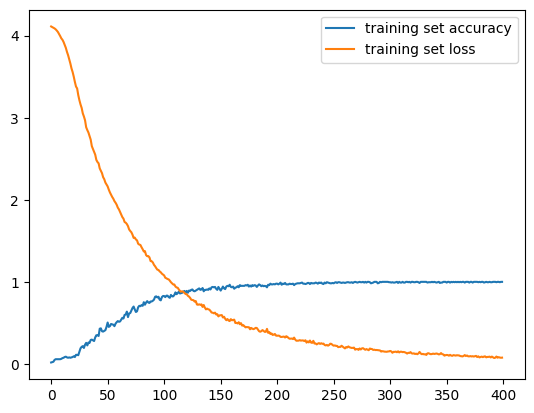

In [106]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.legend()

In [120]:
accr = my_model.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 4s 32ms/step - loss: 0.3560 - accuracy: 0.9823
Train set
  Loss: 0.356
  Accuracy: 0.982


In [121]:
accr = my_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 0s 177ms/step - loss: 2.0452 - accuracy: 0.5385
Test set
  Loss: 2.045
  Accuracy: 0.538


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 14, 16)            2176      
                                                                 
 lstm_1 (LSTM)               (None, 14, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 61)                13725     
                                                                 
Total params: 18,013
Trainable params: 18,013
Non-trainable params: 0
_________________________________________________________________


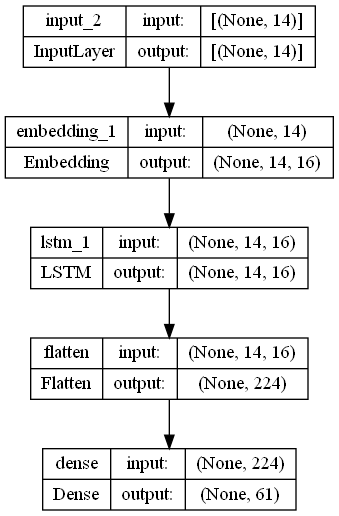

In [29]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model-new/model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
accr = model.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 6s 33ms/step - loss: 0.1254 - accuracy: 0.9823
Train set
  Loss: 0.125
  Accuracy: 0.982


In [30]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 0s 188ms/step - loss: 0.4494 - accuracy: 0.9615
Test set
  Loss: 0.449
  Accuracy: 0.962


In [33]:
print(X_test)

[[  0   0   0   0   0   0   0   0   0   0   1   3  34  15]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  90]
 [  0   0   0   0   0   0   0   0   0   0   0  18  45   5]
 [  0   0   0   0   0   0   0   0   0   0  32  11  10  30]
 [  0   0   0   0   0   0   0   0   0   0   0   8   2   5]
 [  0   0   0   0   0   0   0   0   0   0   0   1  23  24]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  16]
 [  0   0   0   0   0   0   0   0   0   0   1   3  41  14]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  93]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 111]
 [  0  11  26  43  37  48   1   3  12  17   4   2   7   9]
 [  0   0   0   0   0   0   0   0   0   0   0   0  29  30]
 [  0   0   0   0   0   0   0   0   0   0   1   3   2  29]
 [  0   0   0   0   0   0   0   0   1   3   8  40   4  15]
 [  0   0   0   0   0   0  19  54   7  55  73  56  43  38]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  15]
 [  0   0   0   0   0   0   0   0   0   8   4   2  23  2

# Confusion Matrix Training

In [50]:
y_pred_train = model.predict(X_train)

8/8 [==============================] - 0s 28ms/step


In [51]:
prediction_train = []
for i in y_pred_train:
    prediction_train.append(np.argmax(i))

In [52]:
# import libraries
from sklearn.metrics import confusion_matrix
import numpy as np

# create confusion matrix
confusion_matrix = confusion_matrix(Y_train, prediction_train)
print(confusion_matrix)

[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [53]:
from sklearn.metrics import classification_report
print(classification_report(Y_train, prediction_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         4
          14       1.00      0.67      0.80         3
          15       1.00      1.00      1.00         4
          16       0.80      1.00      0.89         4
          17       1.00    

<AxesSubplot: >

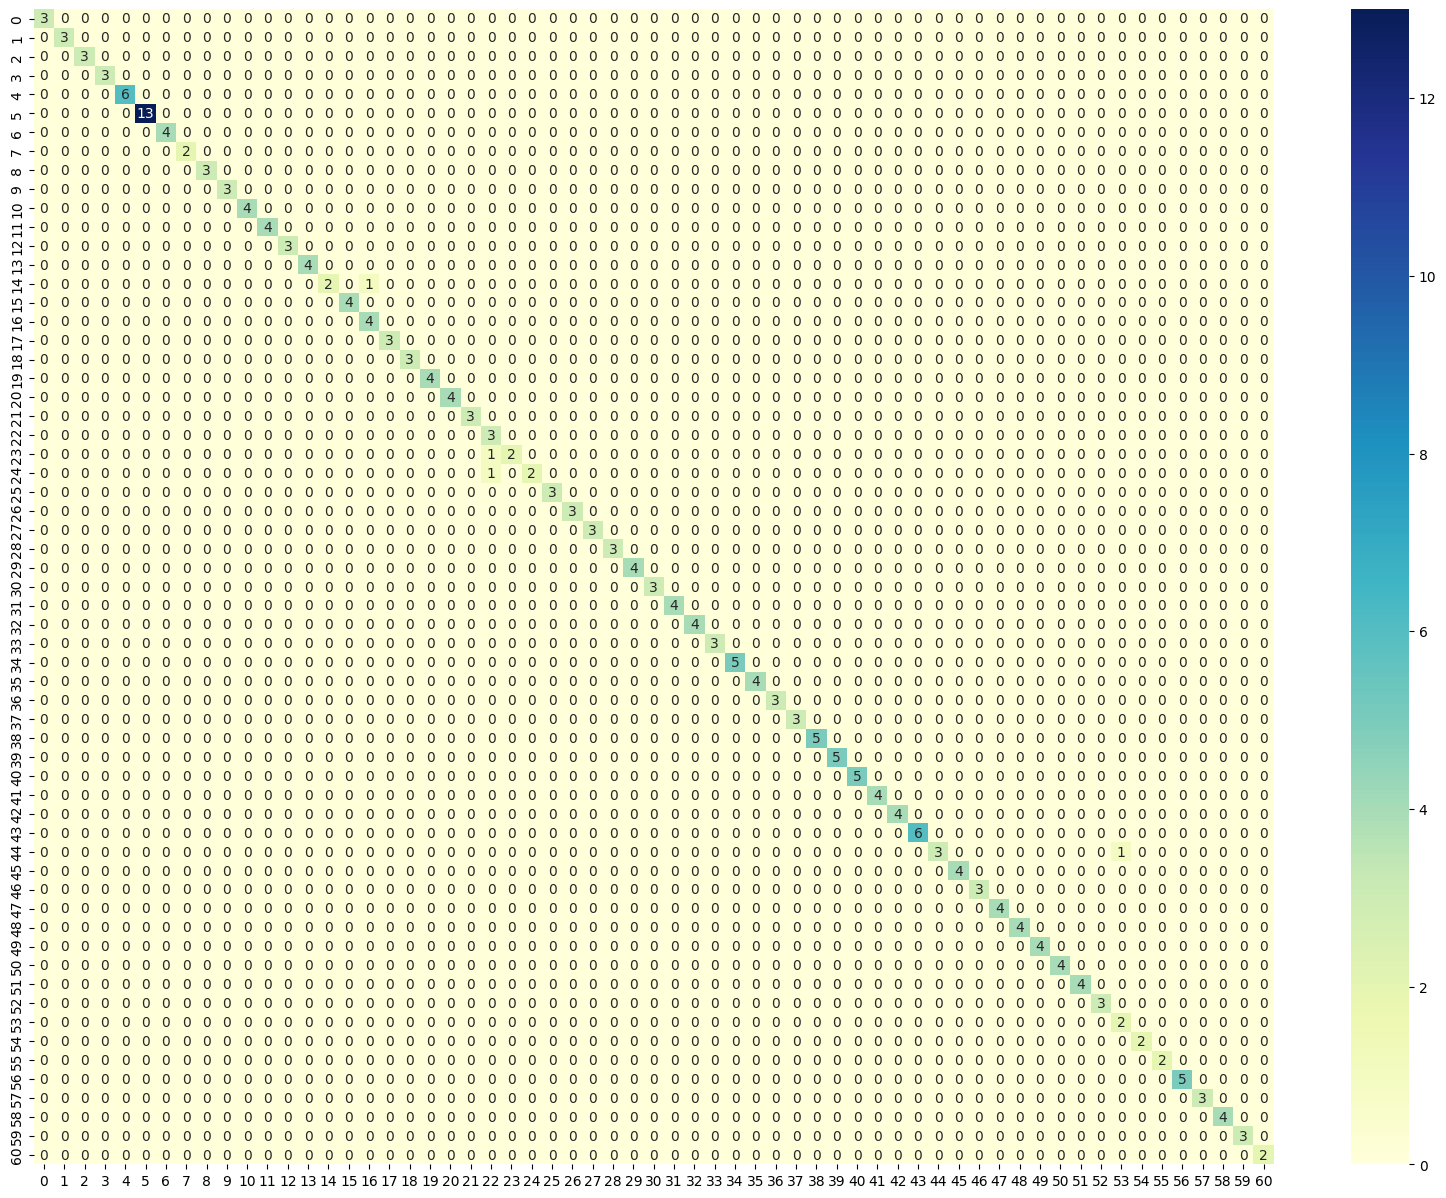

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_matrix = confusion_matrix(Y_train, prediction_train)
warna = sns.light_palette("blue")
plt.figure(figsize=(20,15))
sns.heatmap(c_matrix, annot = True, cmap='YlGnBu')

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score
# calculate precision
precision = precision_score(Y_train, prediction_train, pos_label='positive', average='weighted')
# calculate recall
recall = recall_score(Y_train, prediction_train, pos_label='positive', average='weighted')
# calculate f1-score
f1 = f1_score(Y_train, prediction_train, pos_label='positive', average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9882005899705014
Recall: 0.9823008849557522
F1-score: 0.9824518893102964


C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


# Confusion Matrix Testing

In [62]:
y_pred_test = model.predict(X_test)

1/1 [==============================] - 0s 171ms/step


In [63]:
prediction = []
for i in y_pred_test:
    prediction.append(np.argmax(i))

In [64]:
prediction[:20]

[21, 5, 41, 34, 17, 33, 27, 60, 5, 58, 9, 28, 55, 12, 54, 26, 18, 0, 2, 4]

In [65]:
# import libraries
from sklearn.metrics import confusion_matrix
import numpy as np

# create confusion matrix
confusion_matrix = confusion_matrix(Y_test, prediction)
print(confusion_matrix)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [66]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         1
          21       1.00      1.00      1.00         1
          26       1.00      1.00      1.00         1
          27       1.00      1.00      1.00         1
          28       1.00      1.00      1.00         1
          30       1.00      1.00      1.00         1
          32       1.00      1.00      1.00         1
          33       1.00      1.00      1.00         1
          34       1.00    

C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rhjha\anaconda3\en

<AxesSubplot: >

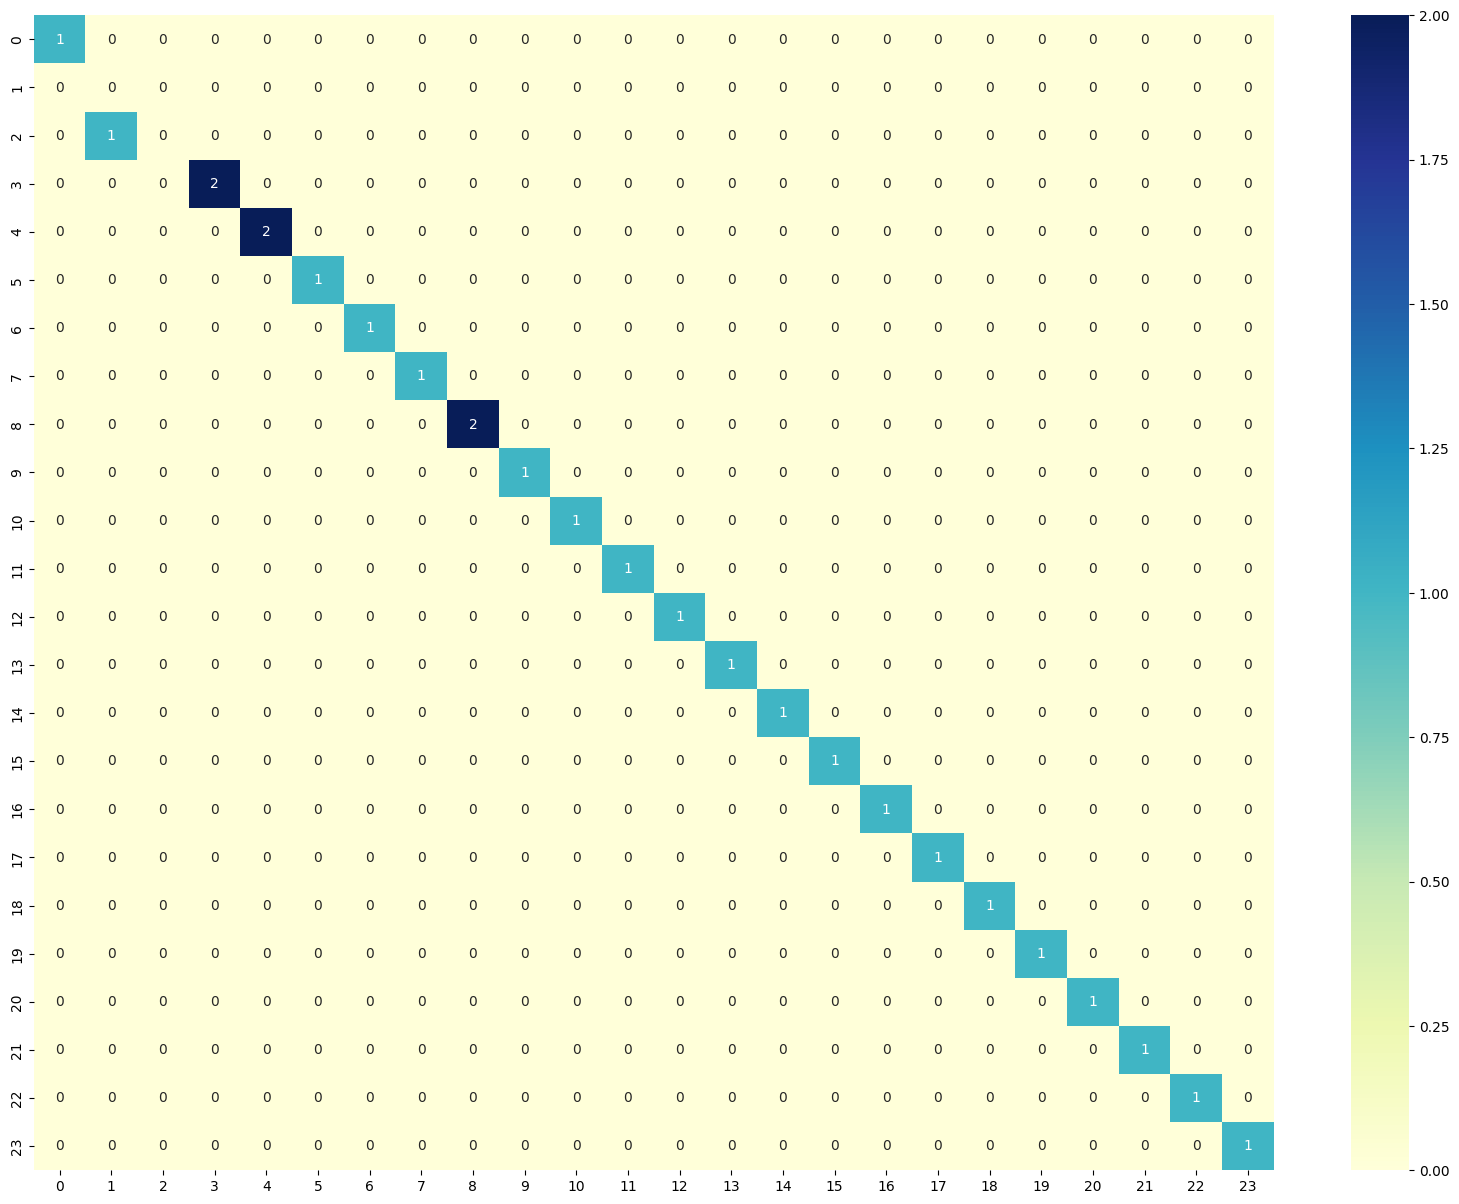

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_matrix = confusion_matrix(Y_test, prediction)
warna = sns.light_palette("blue")
plt.figure(figsize=(20,15))
sns.heatmap(c_matrix, annot = True, cmap='YlGnBu')

In [68]:
from sklearn.metrics import precision_score, recall_score, f1_score
# calculate precision
precision = precision_score(Y_test, prediction, pos_label='positive', average='weighted')
# calculate recall
recall = recall_score(Y_test, prediction, pos_label='positive', average='weighted')
# calculate f1-score
f1 = f1_score(Y_test, prediction, pos_label='positive', average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1-score: 0.9615384615384616


C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricW

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 14, 16)            2176      
                                                                 
 lstm_1 (LSTM)               (None, 14, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 61)                13725     
                                                                 
Total params: 18,013
Trainable params: 18,013
Non-trainable params: 0
_________________________________________________________________


In [53]:
weight = model.layers[2].get_weights()[0]
weight[1]

array([ 2.8188956e-01, -2.8852472e-01,  5.8603799e-01,  3.1799169e-03,
        3.3591887e-01,  5.2236831e-01, -6.0976557e-02,  7.8305088e-02,
        2.9404891e-01, -3.6675766e-02, -1.1282476e-01,  3.4664047e-01,
       -1.9529745e-02,  1.1199477e-01, -2.0686191e-01,  1.0453758e-01,
        2.3235363e-01, -3.0620100e-02,  7.9809919e-02, -5.1775265e-01,
        5.1327813e-02, -4.2341331e-01,  1.0508388e-01, -6.9533877e-02,
       -9.6225977e-01, -6.6570714e-02, -9.1552460e-01, -3.8558972e-01,
       -4.9845347e-01, -7.9421496e-01, -1.4563332e-02, -2.8982762e-01,
       -4.7836900e-01, -2.2592176e-01, -2.6002184e-01,  5.8462948e-01,
       -2.8394377e-01, -1.0743510e-01,  9.4291821e-02, -5.1565075e-01,
        6.6542709e-01,  1.2867217e-01, -6.9721061e-01, -2.4011618e-01,
        3.2941484e-01, -9.8958954e-02,  1.2146503e-01, -4.6525323e-01,
        5.3718674e-01,  1.2491899e-01,  4.0441954e-01,  1.9666864e-02,
        2.8874993e-01, -2.2911960e-02, -7.6795675e-02,  2.9448655e-01,
      

In [54]:
weight.shape

(16, 64)

In [ ]:
result=model.predict(X_train)

In [ ]:
print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

In [46]:
texts_p = []
prediction_input = input('Kamu : ')

# Menghapus punktuasi dan konversi ke huruf kecil
prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
prediction_input = ''.join(prediction_input)
texts_p.append(prediction_input)

# Tokenisasi dan Padding
prediction_input = tokenizer.texts_to_sequences(texts_p)
print(prediction_input)
prediction_input = np.array(prediction_input).reshape(-1)
print(prediction_input)
prediction_input = pad_sequences([prediction_input],input_shape)
print(prediction_input)

# Mendapatkan hasil keluaran pada model 
output = model.predict(prediction_input)
print(output[0])

output = output.argmax()
print(output)

response_tag = le.inverse_transform([output])[0]
print(response_tag)
print("ITTPBot : ", random.choice(responses[response_tag]))

Kamu : bangkit
[[29]]
[29]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0 29]]
1/1 [==============================] - 0s 165ms/step
[7.26422120e-04 8.29987012e-09 2.97623938e-05 6.10004669e-09
 8.41983706e-02 1.21377362e-02 4.54148494e-06 1.94738973e-07
 4.98112260e-14 1.28888957e-12 1.19951830e-04 9.00699291e-04
 8.03562361e-05 5.97679582e-06 2.65550014e-04 3.02907733e-06
 5.24341158e-05 1.73694498e-04 1.36027684e-05 3.64222501e-06
 6.96735327e-08 7.36641368e-06 8.28446173e-06 7.31655291e-07
 5.71541428e-08 1.62033025e-13 3.36245145e-03 1.43117970e-03
 8.67388666e-01 8.95882666e-04 3.77327495e-04 3.30295967e-04
 1.30941742e-03 2.71657016e-03 1.20378025e-02 2.33253172e-06
 4.31250946e-08 3.71898459e-08 1.43886118e-05 3.94679455e-06
 6.66801134e-06 2.64210794e-05 2.58401769e-06 1.23258246e-07
 4.16944713e-05 1.44104197e-05 1.87719008e-04 1.30503213e-06
 1.94740210e-06 1.27286648e-05 7.74241998e-05 2.86371051e-06
 2.85321793e-08 1.21900939e-05 1.24461064e-09 5.45928907e-03
 1.07825663e-05 9.42

AttributeError: 'numpy.ndarray' object has no attribute 'layers'

In [28]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

#   # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("ITTPBot : ", random.choice(responses[response_tag]))
#   tts = gTTS(random.choice(responses[response_tag]), lang='id')
#   # Simpan model voice bot ke dalam Google Drive
#   tts.save('model/ITTPBot.wav')
#   time.sleep(0.08)
#   # Load model voice bot from Google Drive
#   ipd.display(ipd.Audio('model/ITTPBot.wav', autoplay=False))
#   print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

Kamu : hai
1/1 [==============================] - 7s 7s/step
ITTPBot :  Halo! Saya ITTPBot, salam kenal ya! Mau tau tentang kampus merdeka?
Kamu : lokasi kknt
1/1 [==============================] - 0s 172ms/step
ITTPBot :  Desa Melung, Kecamatan Kedungbanteng, Banyumas, Jawa Tengah; Desa Pliken, Kecamatan Kembaran, Banyumas, Jawa Tengah; Desa Baseh, Kecamatan Kedungbanteng, Jawa Tengah
Kamu : program bangkit
1/1 [==============================] - 0s 172ms/step
ITTPBot :  Program Bangkit adalah program kesiapan karier yang didesain oleh Google untuk memberikan mahasiswa Indonesia paparan langsung dengan praktisi industri, serta mempersiapkan mahasiswa dengan keterampilan yang relevan untuk karier sukses di perusahaan teknologi terkemuka.
Kamu : apa saja program bangkit?
1/1 [==============================] - 0s 172ms/step
ITTPBot :  Bangkit menawarkan 3 pilihan jalur pembelajaran yaitu machine learning, mobile development, dan cloud computing. Tidak hanya keterampilan teknologi, Bangkit

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
# model.save('model-new/chat_model.h5')

# print('Model Created Successfully!')

In [27]:
from keras.models import load_model
model = load_model('model-new/chat_model_good.h5')